In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, drop_prob=0):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=drop_prob, batch_first=True)
    
    def forward(self, inputs, hidden):
        # Embed input words
        embedded = self.embedding(inputs)
        # Pass the embedded word vectors into LSTM and return all outputs
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden
    
    def init_hidden(self, batch_size=1):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))

In [3]:
"""
Calculating Alignment Scores
"""
import torch.nn.functional as F

class BahDanauDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, drop_prob=0.1):
        super(BahDanauDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        self.fc_hidden = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc_encoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_size * 2, self.hidden_size, batch_first=True)
        self.classifier = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, inputs, hidden, encoder_outputs):
        encoder_outputs = encoder_outputs.squeeze()
        # Embed input words
        embedded = self.embedding(inputs).view(1, -1)
        embedded = self.dropout(embedded)
        
        # Calculating Alignment Scores
        x = torch.tanh(self.fc_hidden(hidden[0])+self.fc_encoder(encoder_outputs))
        alignment_scores = x.bmm(self.weight.unsquezze(2))
        
        # Softmaxing alignment scores to get Attention weights
        attn_weights = F.softmax(alignment_scores.view(1, -1), dim=1)
        
        # Multiplying the Attention weights with encoder outputs to get the context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(0),
                                  encoder_outputs.unsqueeze(0))
        
        # Concatening context vector with embedded input word
        output = torch.cat((embedded, context_vector[0]), 1).unsqueeze(0)
        # Passing the concatened vector as input to the LSTM cell
        output, hidden = self.lstm(output, hidden)
        # Passing the lstm output through a Linear layer acting as a classifier
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        return output, hidden, attn_weights

In [5]:
class LuongDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, attention, n_layers=1, drop_prob=0.1):
        super(LuongDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        # The Attention Mechanism is defined in a separate class
        self.attention = attention

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.classifier = nn.Linear(self.hidden_size*2, self.output_size)
    
    def forward(self, inputs, hidden, encoder_outputs):
        # Embed input words
        embedded = self.embedding(inputs).view(1,1,-1)
        embedded = self.dropout(embedded)

        # Passing previous output word (embedded) and hidden state into LSTM cell
        lstm_out, hidden = self.lstm(embedded, hidden)

        # Calculating Alignment Scores - see Attention class for the forward pass function
        alignment_scores = self.attention(lstm_out,encoder_outputs)
        # Softmaxing alignment scores to obtain Attention weights
        attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)

        # Multiplying Attention weights with encoder outputs to get context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs)

        # Concatenating output from LSTM with context vector
        output = torch.cat((lstm_out, context_vector),-1)
        # Pass concatenated vector through Linear layer acting as a Classifier
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        return output, hidden, attn_weights


class Attention(nn.Module):
    def __init__(self, hidden_size, method="dot"):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

        # Defining the layers/weights required depending on alignment scoring method
        if method == "general":
            self.fc = nn.Linear(hidden_size, hidden_size, bias=False)
        elif method == "concat":
            self.fc = nn.Linear(hidden_size, hidden_size, bias=False)
            self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
  
    def forward(self, decoder_hidden, encoder_outputs):
        if self.method == "dot":
            # For the dot scoring method, no weights or linear layers are involved
            return encoder_outputs.bmm(decoder_hidden.view(1,-1,1)).squeeze(-1)
        elif self.method == "general":
            # For general scoring, decoder hidden state is passed through linear layers to introduce a weight matrix
            out = self.fc(decoder_hidden)
            return encoder_outputs.bmm(out.view(1,-1,1)).squeeze(-1)
        elif self.method == "concat":
            # For concat scoring, decoder hidden state and encoder outputs are concatenated first
            out = torch.tanh(self.fc(decoder_hidden+encoder_outputs))
            return out.bmm(self.weight.unsqueeze(-1)).squeeze(-1)

In [6]:
import torch.optim as optim
import pandas
import spacy
from spacy.lang.en import English
from spacy.lang.fr import French
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm_notebook
import random
from collections import Counter

if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [9]:
with open("fra.txt", "r+") as file:
    fra = [x[:-1] for x in file.readlines()]
en = []
fr = []
for line in fra:
    en.append(line.split("\t")[0])
    fr.append(line.split("\t")[1])

# Setting the number of training sentences we'll use
training_examples = 10000
# We'll be using the spaCy's English and German tokenizers
spacy_en = English()
spacy_fr = French()

en_words = Counter()
fr_words = Counter()
en_inputs = []
fr_inputs = []

# Tokenizing the English and German sentences and creating our word banks for both languages
for i in tqdm_notebook(range(training_examples)):
    en_tokens = spacy_en(en[i])
    fr_tokens = spacy_fr(fr[i])
    if len(en_tokens)==0 or len(fr_tokens)==0:
        continue
    for token in en_tokens:
        en_words.update([token.text.lower()])
    en_inputs.append([token.text.lower() for token in en_tokens] + ['_EOS'])
    for token in fr_tokens:
        fr_words.update([token.text.lower()])
    fr_inputs.append([token.text.lower() for token in fr_tokens] + ['_EOS'])

# Assigning an index to each word token, including the Start Of String(SOS), End Of String(EOS) and Unknown(UNK) tokens
en_words = ['_SOS','_EOS','_UNK'] + sorted(en_words,key=en_words.get,reverse=True)
en_w2i = {o:i for i,o in enumerate(en_words)}
en_i2w = {i:o for i,o in enumerate(en_words)}
fr_words = ['_SOS','_EOS','_UNK'] + sorted(fr_words,key=fr_words.get,reverse=True)
fr_w2i = {o:i for i,o in enumerate(fr_words)}
fr_i2w = {i:o for i,o in enumerate(fr_words)}

# Converting our English and German sentences to their token indexes
for i in range(len(en_inputs)):
    en_sentence = en_inputs[i]
    fr_sentence = fr_inputs[i]
    en_inputs[i] = [en_w2i[word] for word in en_sentence]
    fr_inputs[i] = [fr_w2i[word] for word in fr_sentence]

<ipython-input-9-3a3873902b04>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(training_examples)):


In [11]:
hidden_size = 256
encoder = EncoderLSTM(len(en_words), hidden_size).to(device)
attn = Attention(hidden_size,"concat")
decoder = LuongDecoder(hidden_size,len(fr_words),attn).to(device)

lr = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

In [12]:
EPOCHS = 10
teacher_forcing_prob = 0.5
encoder.train()
decoder.train()
tk0 = tqdm_notebook(range(1,EPOCHS+1),total=EPOCHS)
for epoch in tk0:
    avg_loss = 0.
    tk1 = tqdm_notebook(enumerate(en_inputs),total=len(en_inputs),leave=False)
    for i, sentence in tk1:
        loss = 0.
        h = encoder.init_hidden()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        inp = torch.tensor(sentence).unsqueeze(0).to(device)
        encoder_outputs, h = encoder(inp,h)
        
        #First decoder input will be the SOS token
        decoder_input = torch.tensor([en_w2i['_SOS']],device=device)
        #First decoder hidden state will be last encoder hidden state
        decoder_hidden = h
        output = []
        teacher_forcing = True if random.random() < teacher_forcing_prob else False
        
        for ii in range(len(fr_inputs[i])):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Get the index value of the word with the highest score from the decoder output
            top_value, top_index = decoder_output.topk(1)
            if teacher_forcing:
                decoder_input = torch.tensor([fr_inputs[i][ii]],device=device)
            else:
                decoder_input = torch.tensor([top_index.item()],device=device)
            output.append(top_index.item())
            # Calculate the loss of the prediction against the actual word
            loss += F.nll_loss(decoder_output.view(1,-1), torch.tensor([fr_inputs[i][ii]],device=device))
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        avg_loss += loss.item()/len(en_inputs)
    tk0.set_postfix(loss=avg_loss)
  # Save model after every epoch (Optional)
torch.save({"encoder":encoder.state_dict(),"decoder":decoder.state_dict(),"e_optimizer":encoder_optimizer.state_dict(),"d_optimizer":decoder_optimizer},"./model.pt")

<ipython-input-12-7f71a29e5c40>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm_notebook(range(1,EPOCHS+1),total=EPOCHS)


<ipython-input-12-7f71a29e5c40>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk1 = tqdm_notebook(enumerate(en_inputs),total=len(en_inputs),leave=False)


English: i was busy . _EOS
Predicted: j' ã © tais occupã © e .
Actual: j' ã © tais occupã © e . _EOS


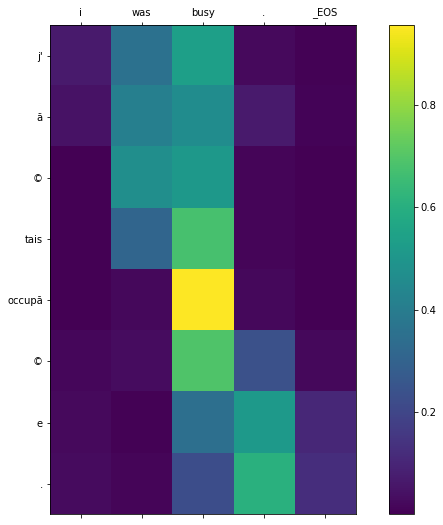

In [13]:
encoder.eval()
decoder.eval()
# Choose a random sentences
i = random.randint(0,len(en_inputs)-1)
h = encoder.init_hidden()
inp = torch.tensor(en_inputs[i]).unsqueeze(0).to(device)
encoder_outputs, h = encoder(inp,h)

decoder_input = torch.tensor([en_w2i['_SOS']],device=device)
decoder_hidden = h
output = []
attentions = []
while True:
    decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
    _, top_index = decoder_output.topk(1)
    decoder_input = torch.tensor([top_index.item()],device=device)
    # If the decoder output is the End Of Sentence token, stop decoding process
    if top_index.item() == fr_w2i["_EOS"]:
        break
    output.append(top_index.item())
    attentions.append(attn_weights.squeeze().cpu().detach().numpy())
print("English: "+ " ".join([en_i2w[x] for x in en_inputs[i]]))
print("Predicted: " + " ".join([fr_i2w[x] for x in output]))
print("Actual: " + " ".join([fr_i2w[x] for x in fr_inputs[i]]))

# Plotting the heatmap for the Attention weights
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
cax = ax.matshow(np.array(attentions))
fig.colorbar(cax)
ax.set_xticklabels(['']+[en_i2w[x] for x in en_inputs[i]])
ax.set_yticklabels(['']+[fr_i2w[x] for x in output])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()